In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.cluster import KMeans

### To-do list
- topics modeling
- clustering
- visualization

In [2]:
class clustering_pipeline:
    def __init__(self, vectorizer, n_components, reducer):
        self.vectorizer = vectorizer
        self.n_dim = n_components
        self.reducer = reducer(n_components)
        
    def fit(self, text):
        self.vectorizer.fit(text)
        self.vector_data = self.vectorizer.fit_transform(text)
        self.topic_data = self.reducer.fit_transform(self.vector_data)
        self.texts = text

    def tsne(self, n_components, perplexity):
        tsne = TSNE(n_components = n_components, perplexity = perplexity)
        plt.figure(dpi=300)
        vector_tsne = tsne.fit_transform(self.topic_data)
        sns.scatterplot(vector_tsne[:, 0], vector_tsne[:, 1],hue=self.labels_, alpha=0.5, size = 0.5, 
                        palette='rainbow', legend='full')
        plt.title(f'tSNE on topic space using {self.cluster_method}');
        plt.figure(dpi=300)
        plt.hist(self.labels_, bins=self.n_clusters);
        
    def kmeans(self, n_clusters):
        self.km = KMeans(n_clusters=n_clusters)
        self.labels_ = self.km.fit_predict(self.vector_data)
        self.cluster_method='kmeans'
        self.n_clusters=n_clusters
        
    def db(self, eps, min_samples):
        db = DBSCAN(eps=eps, min_samples=min_samples).fit(self.x)
        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True
        self.labels_ = db.labels_
        self.cluster_method='db'
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        self.n_clusters=n_clusters

    def spectral(self, article, num_to_return, n_clusters):
        sc = SpectralClustering(n_clusters=n_clusters)
        self.labels_ = sc.fit_predict(self.x)
        self.cluster_method='spectral'
        self.n_clusters=n_clusters
        
    def meanshift(self, quantile, n_samples):
        bandwidth = estimate_bandwidth(self.x, quantile=quantile, n_samples=n_samples)
        ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
        ms.fit(self.x)
        self.labels_ = ms.labels_
        self.cluster_method = 'meanshift'
        cluster_centers = ms.cluster_centers_

        labels_unique = np.unique(self.labels_)
        self.n_clusters_ = len(labels_unique)

        print("number of estimated clusters : %d" % n_clusters_)

        result_texts = [self.texts[i] for i in results[1][0]]
        
        return result_texts

In [3]:
def best_cluster(cluster):
    """
    1. use cosine similarity to find the closes to centroid
    2. print out top documents closest to centroid
    """
    results = np.array([cosine_similarity(vec1, cluster.labels_) for vec1 in cluster.topic_data]).reshape(-1,1)
    sorted_sentences = [sentences[i] for i in np.argsort(results)[::-1]]
    for text in sorted_sentences[:4]:
        print(text)

In [4]:
df = pd.read_pickle('cleaned_df.pkl')
df.head()

Age                                         ReviewText  Rating  \
0   33  Absolutely wonderful - silky and sexy and comf...       4   
1   34  Love this dress!  it's sooo pretty.  i happene...       5   
2   60  I had such high hopes for this dress and reall...       3   
3   50  I love, love, love this jumpsuit. it's fun, fl...       5   
4   47  This shirt is very flattering to all due to th...       5   

   RecommendedIND  PositiveFeedbackCount    DivisionName DepartmentName  \
0               1                      0       Initmates       Intimate   
1               1                      4         General        Dresses   
2               0                      0         General        Dresses   
3               1                      0  General Petite        Bottoms   
4               1                      6         General           Tops   

   ClassName                                       CombinedText  
0  Intimates   Absolutely wonderful - silky and sexy and com...  
1    Dresses   Love this dress!  it's sooo pretty.  i happen...  
2    Dresses  Some major design flaws I had such high hopes ...  
3      Pants  My favorite buy! I love, love, love this jumps...  
4    Blouses  Flattering shirt This shirt is very flattering...

### Create Vectorizer

In [5]:
count_vectorizer = CountVectorizer(ngram_range=(1, 2),  
                                   stop_words='english', 
                                   token_pattern="\\b[a-z][a-z]+\\b",
                                   lowercase=True,
                                   max_df = 0.6)
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),  
                                   stop_words='english', 
                                   token_pattern="\\b[a-z][a-z]+\\b",
                                   lowercase=True,
                                   max_df = 0.6)

cv_data = count_vectorizer.fit_transform(df.ReviewText)
tfidf_data = tfidf_vectorizer.fit_transform(df.ReviewText)

In [6]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        
def display_topics2(model, feature_names, no_top_words=10, topic_names = None):
    for index, topic in enumerate(model.components_):
        if not topic_names or not topic_names[index]:
            print(f"\nTopic {index}")
        else:
            print(f"\nTopic {topic_names[index]}:")
        msg = ", ".join([f'{feature_names[i]} ({topic[i]:6.4f})' 
                             for i in topic.argsort()[:-no_top_words-1:-1]])
        print(msg)

In [7]:
n_comp = 20
lsa_tfidf = TruncatedSVD(n_components=n_comp)
lsa_cv = TruncatedSVD(n_components=n_comp)
nmf_tfidf = NMF(n_components=n_comp)
nmf_cv = NMF(n_components=n_comp)

lsa_tfidf_data = lsa_tfidf.fit_transform(tfidf_data)
lsa_cv_data = lsa_cv.fit_transform(cv_data)
nmf_tfidf_data = nmf_tfidf.fit_transform(tfidf_data)
nmf_cv_data = nmf_cv.fit_transform(cv_data)

In [30]:
display_topics2(lsa_tfidf, tfidf_vectorizer.get_feature_names(),10)


Topic 0
dress (0.2655), love (0.2073), size (0.2073), fit (0.1703), great (0.1684), wear (0.1538), like (0.1528), small (0.1391), just (0.1354), color (0.1201)

Topic 1
dress (0.8179), love dress (0.1724), beautiful (0.0676), dress beautiful (0.0570), slip (0.0536), beautiful dress (0.0515), dress dress (0.0442), dresses (0.0437), dress comfortable (0.0393), dress fits (0.0385)

Topic 2
love (0.3452), great (0.3243), comfortable (0.1875), jeans (0.1559), soft (0.1193), love love (0.1125), perfect (0.0991), super (0.0853), compliments (0.0837), looks great (0.0833)

Topic 3
size (0.4416), true size (0.2858), true (0.2847), fits (0.1891), love (0.1558), small (0.1291), fits true (0.1217), great (0.0982), runs (0.0874), perfect (0.0860)

Topic 4
true (0.2757), true size (0.2732), size (0.2718), fit (0.1612), like (0.1372), fits true (0.1122), skirt (0.0951), nice (0.0951), look (0.0902), quality (0.0870)

Topic 5
love (0.5033), love love (0.2022), shirt (0.1406), true (0.1217), true size

In [9]:
display_topics(lsa_cv, count_vectorizer.get_feature_names(),10)


Topic  0
dress, size, love, fit, like, wear, just, great, small, fabric

Topic  1
dress, love dress, slip, dresses, beautiful, dress beautiful, beautiful dress, dress dress, wedding, bought dress

Topic  2
size, small, fit, ordered, true, true size, large, medium, petite, size small

Topic  3
like, look, just, really, fabric, looks, nice, looked, model, didn

Topic  4
great, wear, fit, small, medium, perfect, jeans, usually, bought, large

Topic  5
wear, small, medium, usually, large, runs, usually wear, shirt, fits, retailer

Topic  6
fit, small, love, just, ordered, medium, xs, large, petite, usually

Topic  7
just, fabric, really, color, right, little, beautiful, ordered, bit, cute

Topic  8
small, great, medium, ordered, love, looks, like, large, runs, look

Topic  9
just, great, like, jeans, right, wear, love, look, small, looks

Topic  10
color, sweater, petite, perfect, ordered, xs, length, long, bought, blue

Topic  11
shirt, little, really, cute, material, look, petite, flatt

In [31]:
display_topics2(nmf_tfidf, tfidf_vectorizer.get_feature_names(),10)


Topic 0
like (2.4618), look (1.3725), really (1.3223), fabric (1.1227), nice (0.8318), good (0.7605), looks (0.7321), material (0.6804), model (0.5767), quality (0.5660)

Topic 1
dress (2.3334), love dress (0.3489), beautiful (0.1738), slip (0.1511), flattering (0.1396), dress beautiful (0.1325), beautiful dress (0.1249), dress dress (0.1203), dresses (0.1203), dress flattering (0.0928)

Topic 2
wear (1.9289), compliments (0.5582), bought (0.4161), usually wear (0.3466), time (0.2921), wore (0.2809), underneath (0.2738), wait (0.2703), usually (0.2692), easy (0.2589)

Topic 3
size (1.6500), true (1.1891), true size (1.1691), fits true (0.3996), fit true (0.2404), runs true (0.2031), usual (0.1238), usual size (0.1193), size size (0.1187), ordered size (0.1099)

Topic 4
small (1.9185), medium (0.8149), ordered (0.3652), size small (0.3532), usually (0.3373), small medium (0.2792), size (0.2448), ordered small (0.2430), extra (0.2373), extra small (0.2306)

Topic 5
love (2.3744), love l

In [11]:
display_topics(nmf_cv, count_vectorizer.get_feature_names(),10)


Topic  0
love, love love, love dress, colors, absolutely, fits, absolutely love, style, wanted love, design

Topic  1
dress, beautiful, love dress, flattering, dresses, slip, material, comfortable, summer, bust

Topic  2
size, true, true size, usual, fits, usual size, large, smaller, runs, ordered

Topic  3
like, looks, feel, model, looks like, don, feel like, looked, look like, material

Topic  4
fit, fit perfectly, perfectly, waist, size fit, loose, tight, better, fit great, fit like

Topic  5
wear, usually wear, usually, bra, wait, normally wear, bought, underneath, wear size, normally

Topic  6
great, looks, looks great, quality, fits, fit great, fall, look great, fits great, great quality

Topic  7
just, right, just right, didn, beautiful, just didn, work, bit, dress just, got

Topic  8
small, medium, large, usually, runs, size small, ordered, small medium, extra, retailer

Topic  9
fabric, nice, soft, quality, cut, beautiful, fabric soft, design, fabric nice, bit

Topic  10
colo

### Clustering

In [8]:
from sklearn.metrics import silhouette_score

SSEs = []
Sil_coefs = []
for k in range(2,10):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(lsa_tfidf_data)
    labels = km.labels_
    Sil_coefs.append(silhouette_score(lsa_tfidf_data, labels, metric='euclidean'))
    SSEs.append(km.inertia_) 

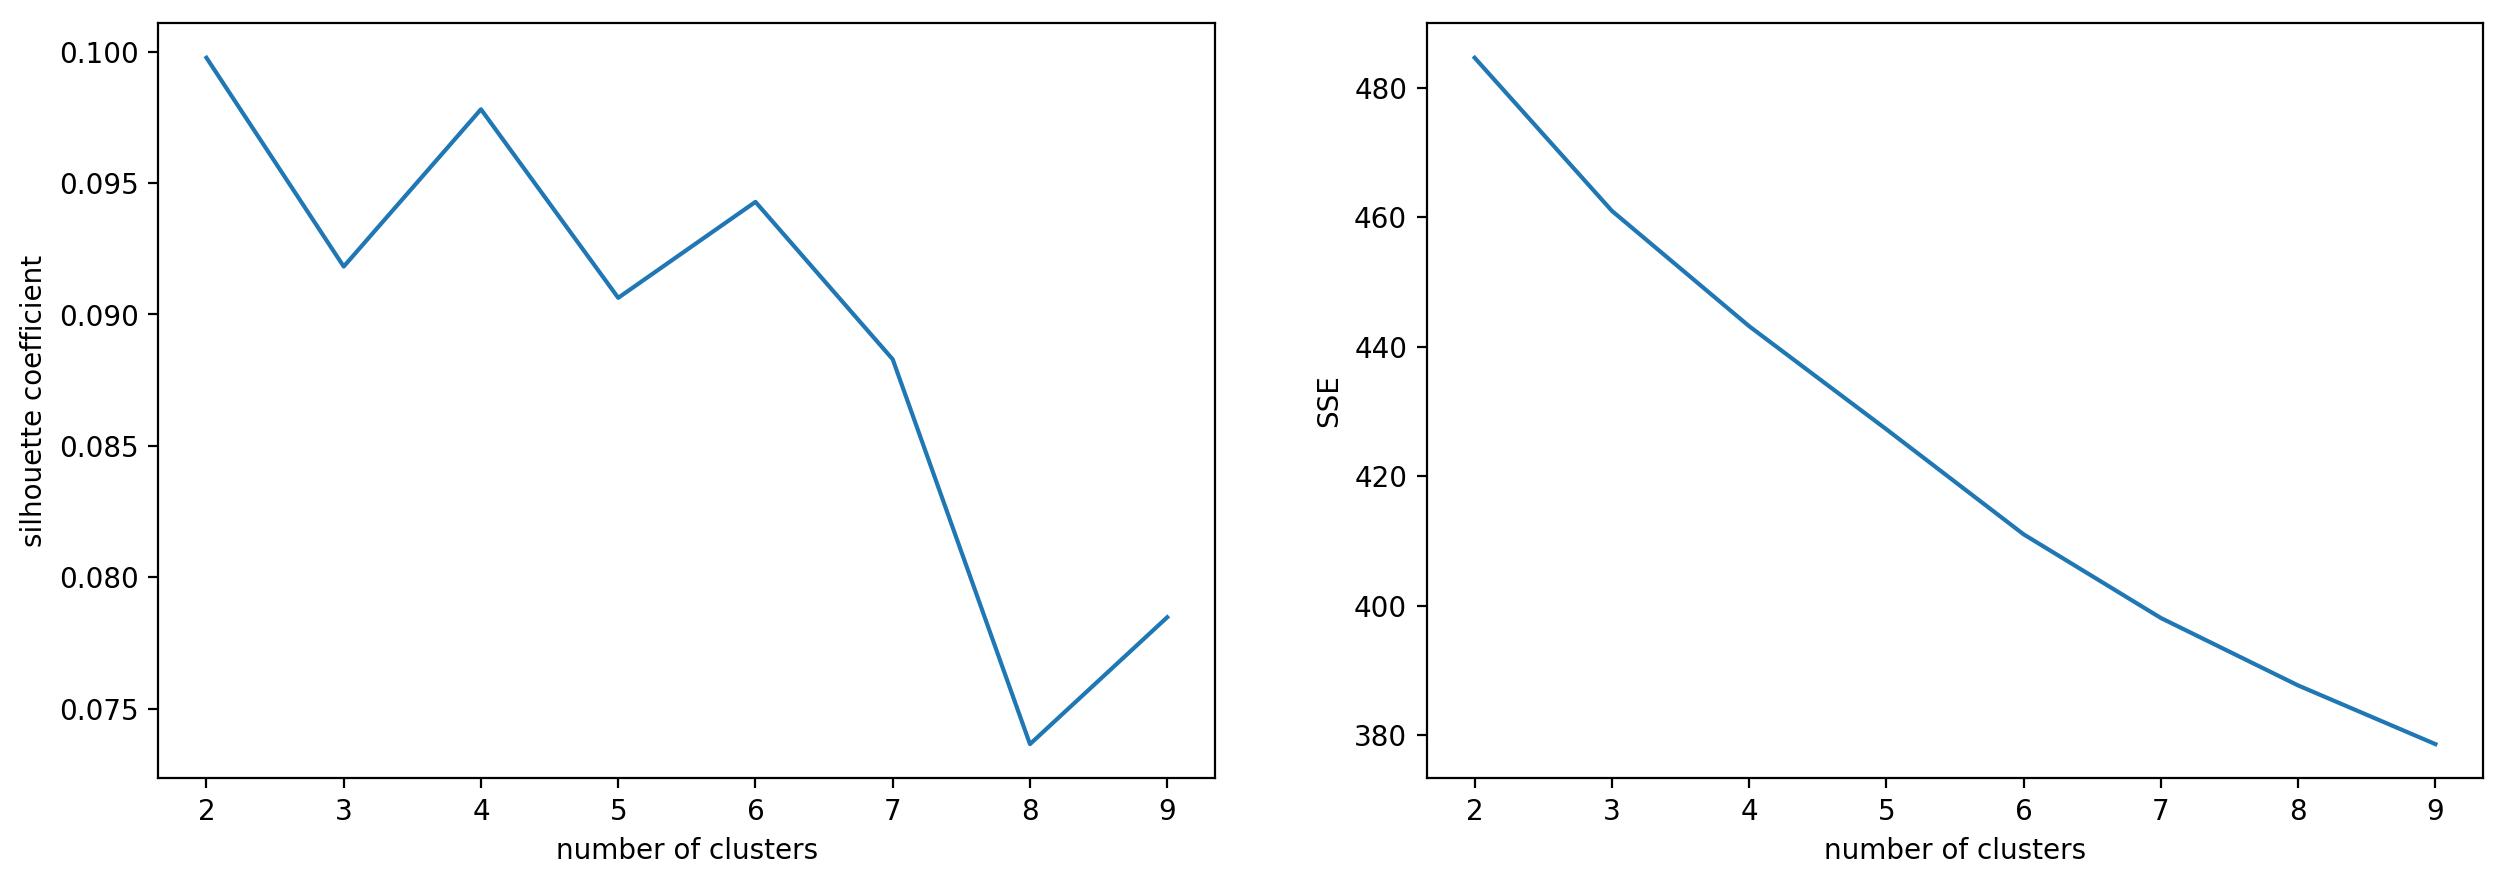

In [9]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), sharex=True, dpi=200)
k_clusters = range(2,10)
ax1.plot(k_clusters, Sil_coefs)
ax1.set_xlabel('number of clusters')
ax1.set_ylabel('silhouette coefficient')

# plot here on ax2
ax2.plot(k_clusters, SSEs)
ax2.set_xlabel('number of clusters')
ax2.set_ylabel('SSE');

In [10]:
from sklearn.metrics import silhouette_score

inertia = [0,0]

for n_clusters in range(2, 25):
    km = KMeans(n_clusters = n_clusters)
    km.fit(lsa_tfidf_data)
    msg = f"""# clusters: {n_clusters:2d}   Inertia: {km.inertia_:8.6f}"""
    inertia.append(km.inertia_)
    print(msg)

# clusters:  2   Inertia: 484.640568
# clusters:  3   Inertia: 460.983698
# clusters:  4   Inertia: 443.164323
# clusters:  5   Inertia: 427.226538
# clusters:  6   Inertia: 411.000340
# clusters:  7   Inertia: 398.069844
# clusters:  8   Inertia: 387.652656
# clusters:  9   Inertia: 378.585966
# clusters: 10   Inertia: 370.524228
# clusters: 11   Inertia: 361.175545
# clusters: 12   Inertia: 353.119168
# clusters: 13   Inertia: 346.294666
# clusters: 14   Inertia: 341.854826
# clusters: 15   Inertia: 334.435527
# clusters: 16   Inertia: 330.865769
# clusters: 17   Inertia: 325.911995
# clusters: 18   Inertia: 322.398389
# clusters: 19   Inertia: 318.589758
# clusters: 20   Inertia: 315.492022
# clusters: 21   Inertia: 312.504247
# clusters: 22   Inertia: 310.061638
# clusters: 23   Inertia: 307.134662
# clusters: 24   Inertia: 304.955254


(200, 500)

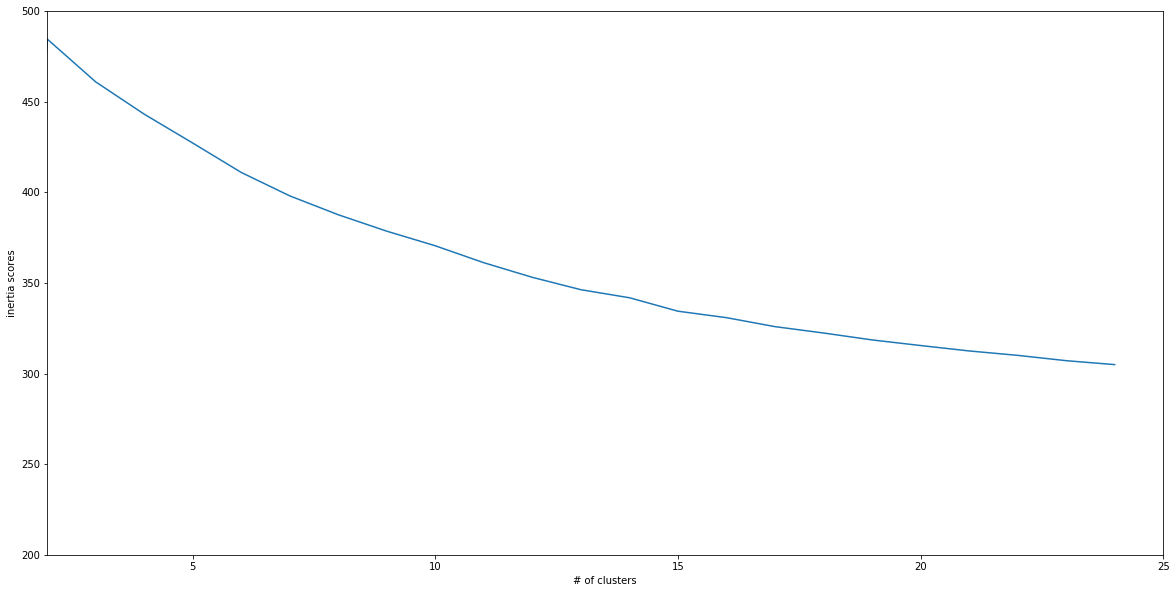

In [11]:
plt.figure(figsize=(20,10))
plt.plot(inertia)
plt.xlabel('# of clusters')
plt.xlim((2,25))
plt.ylabel('inertia scores')
plt.ylim((200,500))

# Testing the class and tsne

In [34]:
test = clustering_pipeline(count_vectorizer, n_components=20, reducer=TruncatedSVD)

In [36]:
test.fit(df.ReviewText)

In [37]:
test.kmeans(10)

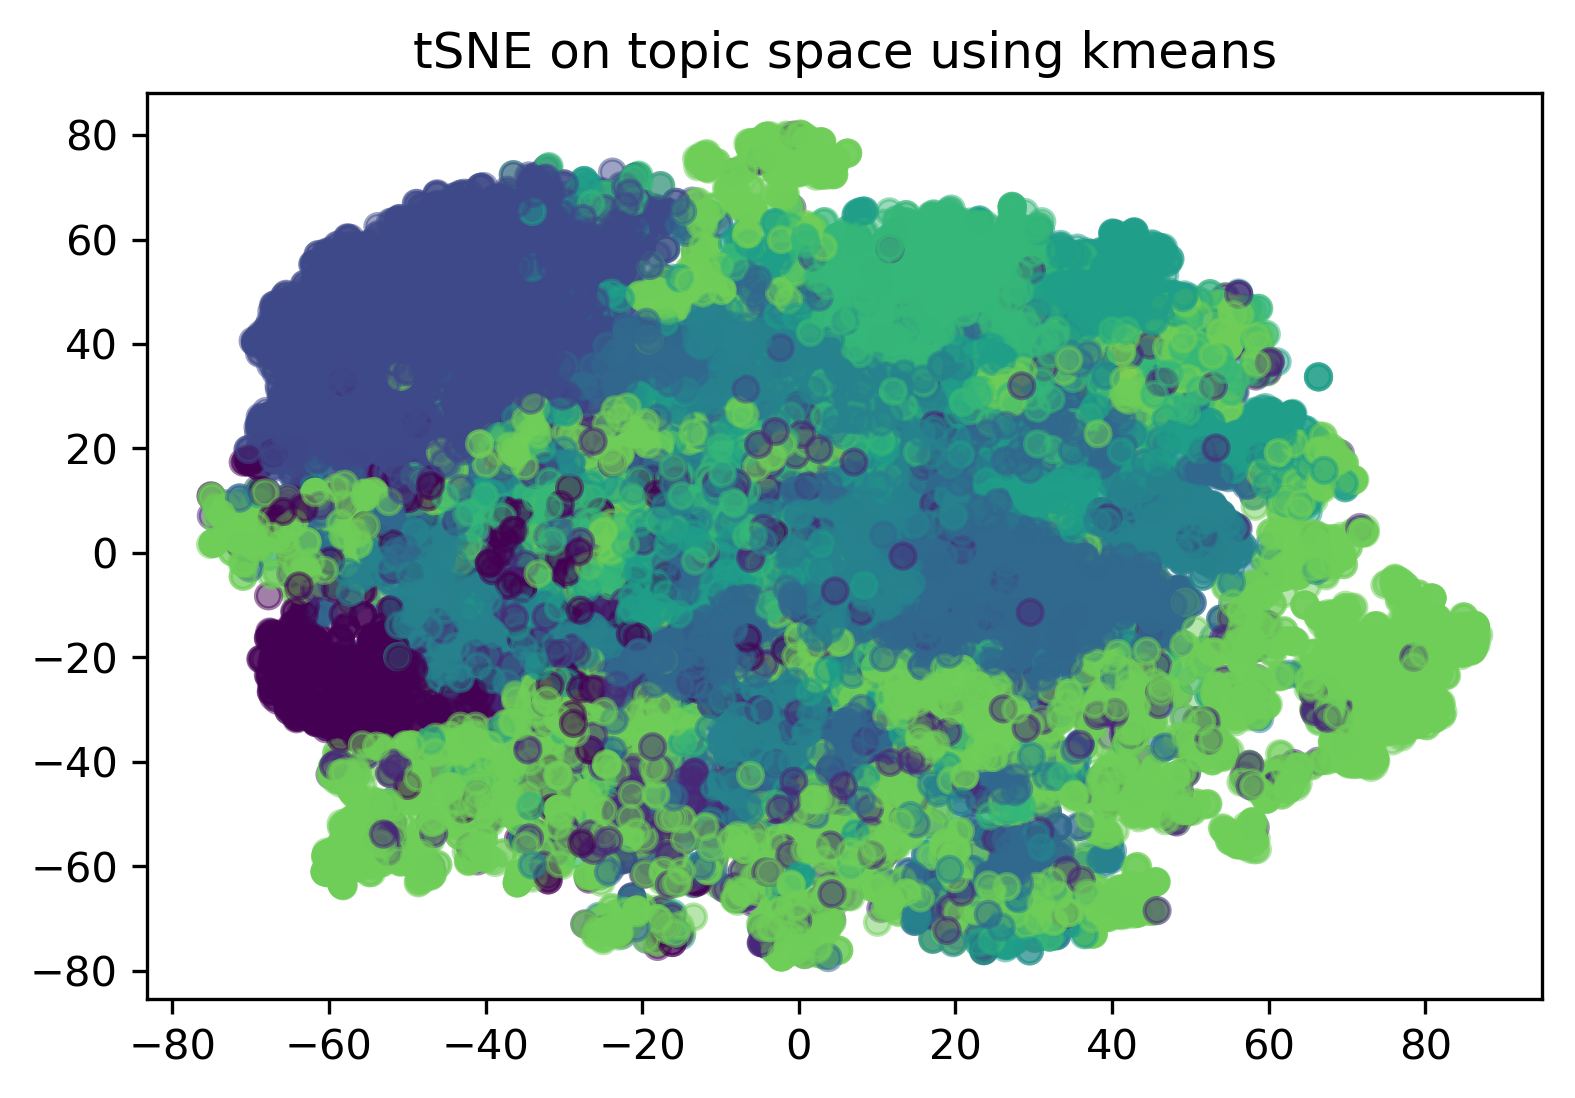

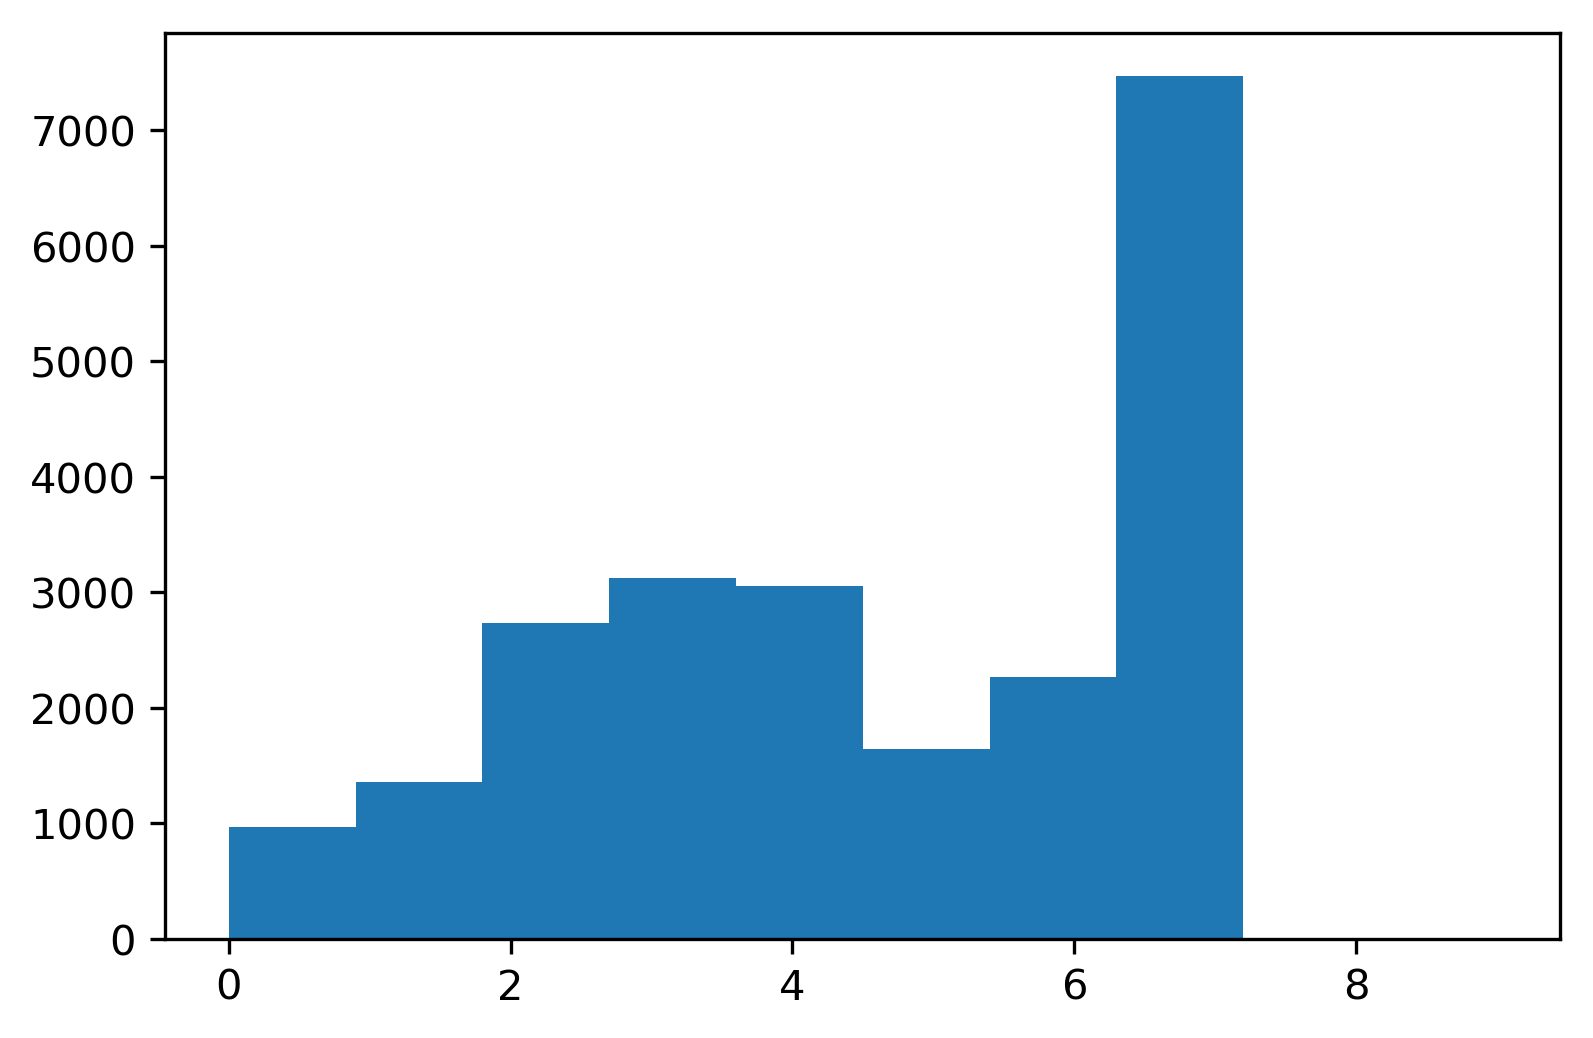

In [39]:
from sklearn.manifold import TSNE
test.tsne(2, 20)

In [12]:
test = clustering_pipeline(count_vectorizer, n_components=50, reducer=TruncatedSVD)

In [13]:
test.fit(df.ReviewText)

In [14]:
test.kmeans(10)

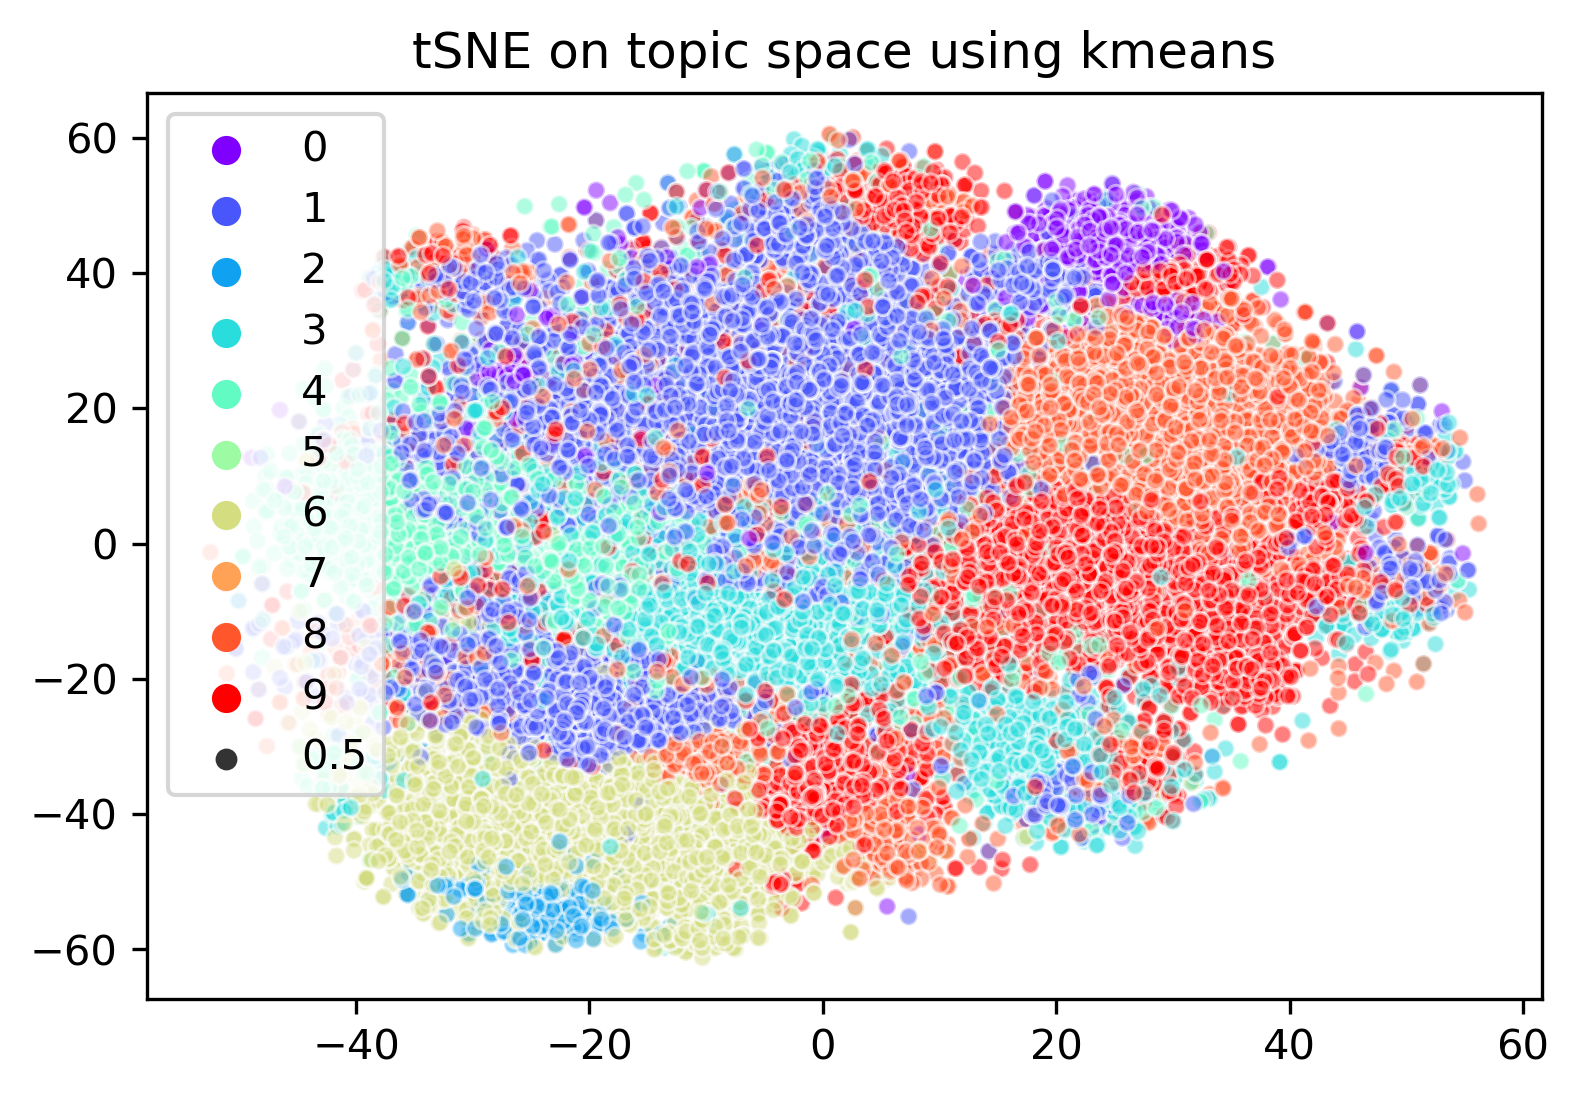

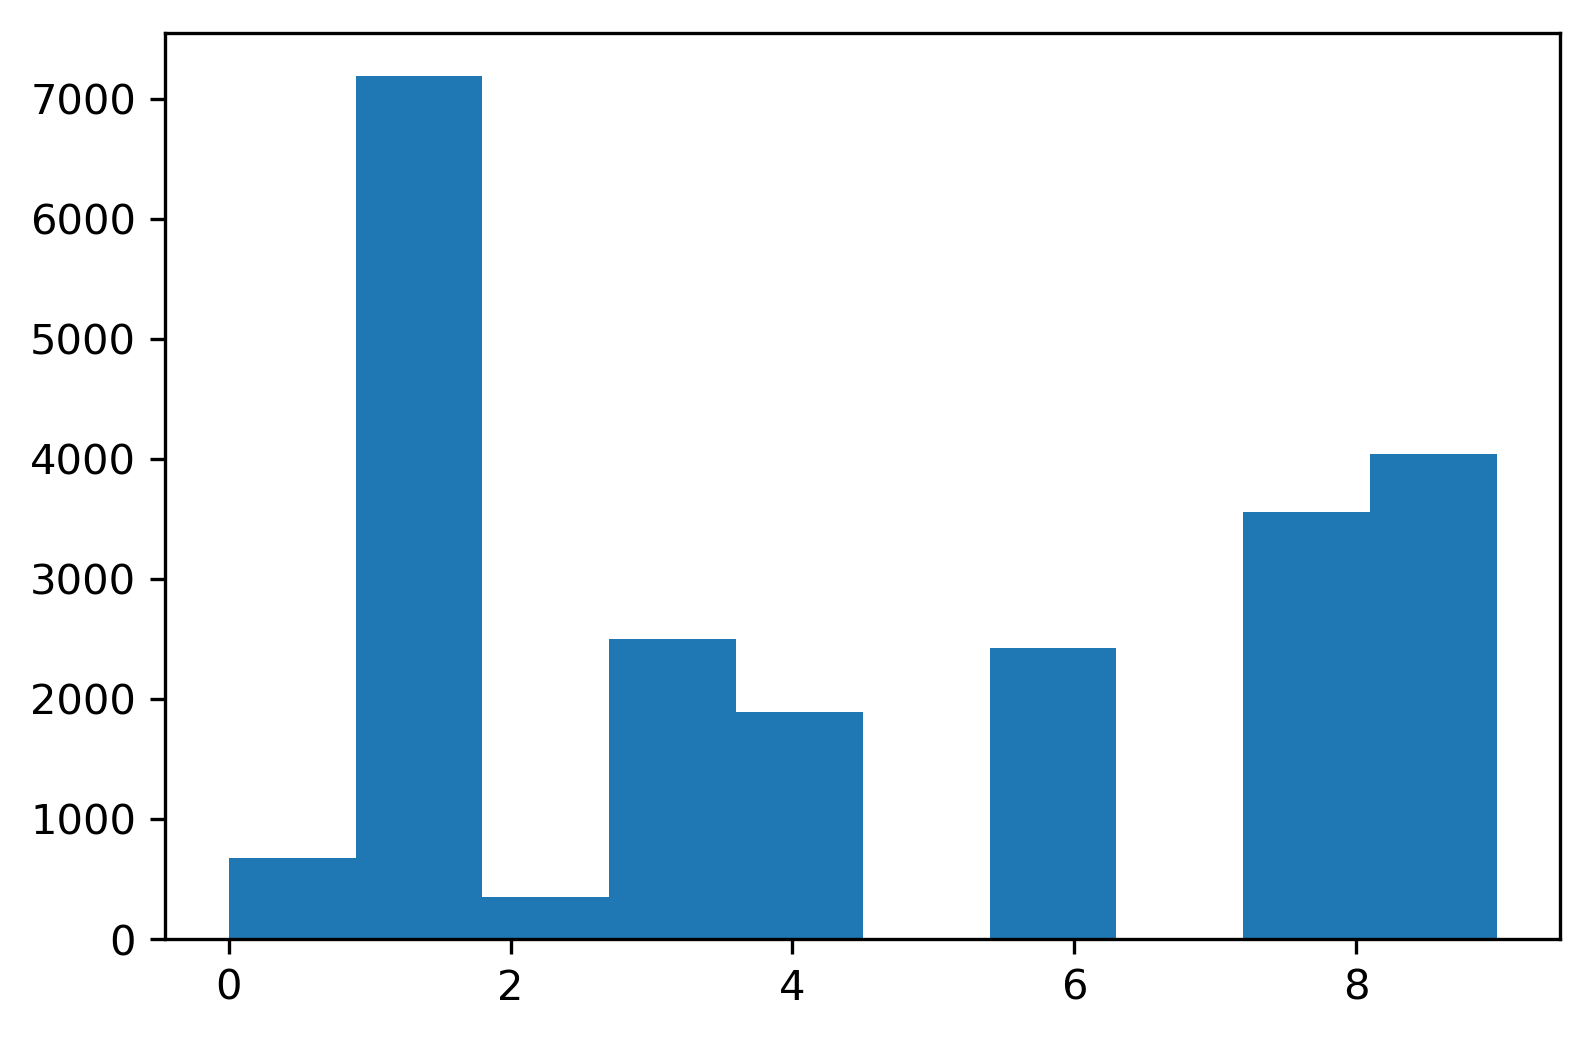

In [15]:
from sklearn.manifold import TSNE
test.tsne(2, 50)

In [ ]:
tsne = TSNE(n_components = 2, perplexity = 50)
vector_tsne = tsne.fit_transform(test.topic_data)

In [58]:
import seaborn as sns

In [60]:
from importlib import reload

IndexError: tuple index out of range

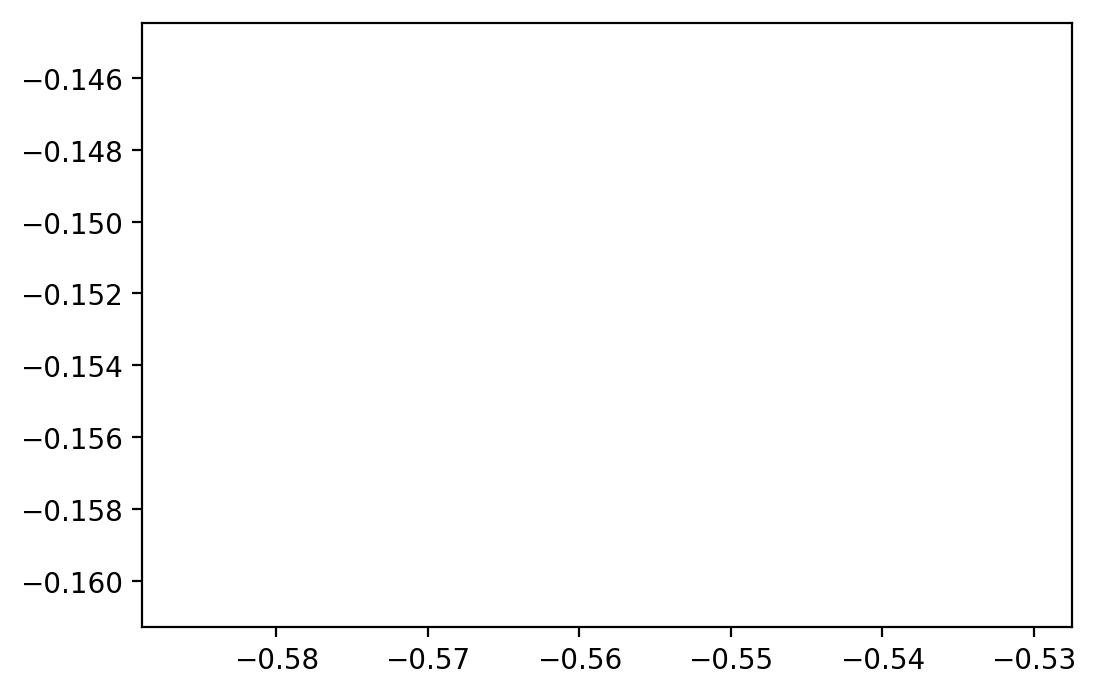

In [71]:
sns.scatterplot()

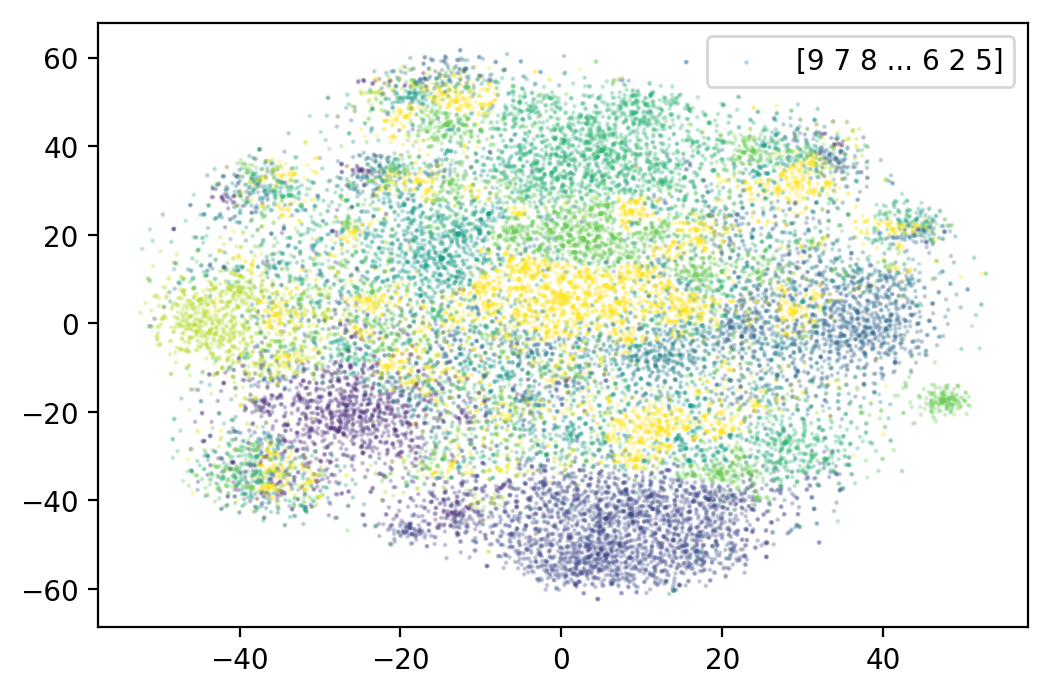

In [55]:
plt.rcParams.update({'figure.dpi': 200})
plt.scatter(vector_tsne[:, 0], vector_tsne[:, 1], c=test.labels_, alpha=0.25, s = 0.5);